# MOPS for KBmod and CFHT data

Based off the CNN developed for the first ML search of the New Horizons 2020 search


In [1]:
import os, glob, sys
import time

import random
"""Import the basics: numpy, pandas, matplotlib, etc."""
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyl
import matplotlib.gridspec as gridspec
import pickle
"""Import keras and other ML tools"""
import tensorflow as tf
import keras

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv3D, Conv2D, MaxPool3D, MaxPool2D
from keras.layers.core import Dropout, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
"""Import scikit learn tools"""
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
"""Import astropy libraries"""
from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D
from astropy.visualization import interval

from trippy import tzscale
from trippy.trippy_utils import expand2d, downSample2d

from convenience_utils import calc_ecliptic_angle

from utils import shuffle

from ensemble_resnet import resnet_model

In [2]:

image_data_type = 'float32'

batch_size = 4096
dropout_rate = 0.2
test_fraction = 0.05
select_bad_at_random = True
badGoodRatio = 1.6 #1.6 seems max
bad_edge_enhancement = 0.002
learning_rate = 0.0007
epochs = 100
number_models = 3

useMedForNans = False #otherwise zero is used
useZscale = False


shuffle_augment = True # shuffle bootstrapping augmentation
double_flip = True # mirror vertically and horizontally augmentation
add_noise = False
rotate_augment = True
noise_level=3.0


nukeBright = 25.5 # if set to a real value, all fainter planted source associations will be set to false
nukeFaint = 27.0 # if set to a real value, all fainter planted source associations will be set to false
dist_lim = 2.0 #association to planted source
rate_diff_lim = 30.0

save_model_iteration = False

useSampleWeights = True

useTripletGrids = True



"""These are some of the flags."""
visits = ['2022-08-21', '2022-08-22', '2022-08-23']

chips = []
#for i in range(103,-1,-1):
for i in range(40):
    chips.append(str(i).zfill(2))
#chips = ['031','050']
   

if add_noise:
    epochs = 400
    learning_rate *= 1.5

# Data Exploration

First read in the data, and make it look like the data from the tutorial



In [3]:

# load the data
#sns_frames = []
n_edge_added = 0
n_bad_total = 0

reference_fits_images = []
ecl_angles = []
kb_xys,fs = [],[]
for i, c in enumerate(chips):
    for j, v in enumerate(visits):
        warps_path = f'/media/fraserw/SecondStage/Projects/kbmod/DATA/rerun/diff_warpCompare/deepDiff/{v}/warps'
        fits_files = glob.glob(f'{warps_path}/{c}/DIFFEXP*fits')
        reference_fits_images.append(fits_files[0])
        ecl_ang = calc_ecliptic_angle(reference_fits_images[-1])
        ecl_angles.append(ecl_ang)
        if c=='20':
            ref_ecl_ang = ecl_ang
            print(ref_ecl_ang)
ecl_angles = np.array(ecl_angles)
rots = (ref_ecl_ang-ecl_angles)*180./np.pi
print(len(rots))
corners = np.array([-270., -180., -90., 0., 90., 180., 270.])
for i,r in enumerate(rots):
    rot = corners[np.argmin(np.abs(r-corners))]
    #print(rot)
    if rot<0: 
        rot+=360.
    #print(chips[i%len(chips)],r,rot)
    print(f'"{str(chips[i%len(chips)])}":',int(rot/90.),',',end=' ')
    rots[i] = rot/90.
rots = rots.astype(np.int)
print(rots)

2.778706123406129
2.7785185865000925
2.778751568744698
120
"00": 2 , "01": 2 , "02": 2 , "03": 2 , "04": 2 , "05": 2 , "06": 2 , "07": 2 , "08": 2 , "09": 2 , "10": 2 , "11": 2 , "12": 2 , "13": 2 , "14": 2 , "15": 2 , "16": 2 , "17": 2 , "18": 2 , "19": 2 , "20": 2 , "21": 2 , "22": 2 , "23": 2 , "24": 2 , "25": 2 , "26": 2 , "27": 2 , "28": 2 , "29": 2 , "30": 2 , "31": 2 , "32": 2 , "33": 2 , "34": 2 , "35": 2 , "36": 2 , "37": 2 , "38": 2 , "39": 2 , "00": 2 , "01": 2 , "02": 2 , "03": 2 , "04": 2 , "05": 2 , "06": 2 , "07": 2 , "08": 2 , "09": 2 , "10": 2 , "11": 2 , "12": 2 , "13": 2 , "14": 0 , "15": 0 , "16": 0 , "17": 0 , "18": 0 , "19": 0 , "20": 0 , "21": 0 , "22": 0 , "23": 0 , "24": 0 , "25": 0 , "26": 0 , "27": 0 , "28": 0 , "29": 0 , "30": 0 , "31": 0 , "32": 0 , "33": 0 , "34": 0 , "35": 0 , "36": 0 , "37": 0 , "38": 0 , "39": 0 , "00": 0 , "01": 0 , "02": 0 , "03": 0 , "04": 0 , "05": 0 , "06": 0 , "07": 0 , "08": 0 , "09": 0 , "10": 0 , "11": 0 , "12": 0 , "13": 0 , "

In [4]:
gridType = ''
if useTripletGrids:
    gridType = '_tg'
    
stamp_files = []
counter = 0
for i, c in enumerate(chips):
    for j, v in enumerate(visits):
        warps_path = f'/media/fraserw/SecondStage/Projects/kbmod/DATA/rerun/diff_warpCompare/deepDiff/{v}/warps'
        stamps_path = warps_path#f'/media/fraserw/rocketdata/Projects/kbmod/stamps/{v}'
        plantLists_path = f'/media/fraserw/SecondStage/Projects/kbmod/DATA/rerun/diff_warpCompare/deepDiff/{v}/plantLists'
        reference_fits_images.append(glob.glob(f'{warps_path}/{c}/DIFFEXP*fits')[0])

        stamp_files.append(f'{stamps_path}/stamps{gridType}_{c}_w_sr.pickle')
        
        ### get the image header and setup a WCS
        with fits.open(reference_fits_images[-1]) as han:
            header = han[1].header
            (A,B) = han[1].data.shape
            
        im_wcs = wcs.WCS(header)

        
        ### load the kbmod results
        kb_xy = []
        with open(f'/media/fraserw/rocketdata/Projects/kbmod/kbmod_results/{v}/results_{c}/results_.txt') as han:
            data = han.readlines()

        for ii in range(len(data)):
            s = data[ii].split()
            x, y = float(s[5]), float(s[7])
            repeat = False
            for jj in range(len(kb_xy)):
                if kb_xy[jj][0]==x and kb_xy[jj][1]==y:
                    repeat = True
                    break
            if not repeat:
                kb_xy.append([float(s[5]) , float(s[7]) , float(s[9]), float(s[11]), float(s[1]), 0.0])
        kb_xy = np.array(kb_xy)
        
        ### load the plantlist sources
        p_xy = []
        plantLists = glob.glob(f'{plantLists_path}/{c}/*plantList')
        plantLists.sort()
        with open(plantLists[0]) as han:
            data = han.readlines()
                
        for ii in range(1,len(data)):
            s = data[ii].split()
            ra,dec = float(s[1]), float(s[2])
            rate = float(s[5])*24./0.187
            coord = np.array(im_wcs.all_world2pix(ra, dec, 0))

            x,y = coord[0],coord[1]
            #x = float(s[3]) + offsets[c][0]
            #y = float(s[4]) + offsets[c][1]
            repeat = False
            for jj in range(len(p_xy)):
                if p_xy[jj][0] == x and p_xy[jj][1]==y:
                    p_xy[jj][2]-=0.75
                    repeat = True

            if not repeat:
                p_xy.append([x, y, float(s[9]), rate, 0])

                
        if len(p_xy)>0:
            p_xy = np.array(p_xy)
            p_xy = p_xy[np.argsort(p_xy[:,2])]
            p_xy = p_xy[np.where((p_xy[:,2]>nukeBright)&(p_xy[:,2]<nukeFaint))]

            #label the good and bad sources
            for ii in range(len(p_xy)):
                d = ((p_xy[ii, 0] - kb_xy[:, 0])**2 + (p_xy[ii, 1] - kb_xy[:, 1])**2 )**0.5
                d_rate = (p_xy[ii, 3] - (kb_xy[:, 2]**2 + kb_xy[:, 3]**2)**0.5)
                ww = np.where((d<dist_lim)&(np.abs(d_rate)<rate_diff_lim))
                if len(ww[0])>0:
                    for arg in ww[0]:
                        kb_xy[arg,-1] = p_xy[ii,2]
                    
        w_bad = np.where(kb_xy[:,-1]==0)
        w_good = np.where(kb_xy[:,-1]>0)
        print(v, c, len(w_bad[0]), len(w_good[0]), len(kb_xy))

        #load the stamps
        with open(stamp_files[-1], 'rb') as han:
            f = pickle.load(han)
        
        ### clip to avoid the crazy min pixel values
        f = np.clip(f, -3500., np.max(f))
        f_med = np.nanmedian(f)
        
        n_good = len(w_good[0])
        
        n_bad_keep = max(1, int(n_good*badGoodRatio))
        if n_bad_keep>0:
            if not select_bad_at_random:
                # sequential selection
                step = int(len(w[0])/n_bad_keep)
                w = w_bad[0][np.arange(0,len(w_bad[0]),step)]
            else:
                # random selection
                w = w_bad[0][(np.random.rand(n_bad_keep)*len(w_bad[0])).astype(np.int)]

        ### add edge bad sources
        if bad_edge_enhancement>0:
            NN = 0
            w_edge = np.where((kb_xy[:, -1] ==0) & ((kb_xy[:,0]<25) | ((B-kb_xy[:,0])<20) | (kb_xy[:, 1]<25) | ((A-kb_xy[:,1])<20)))
            n_edge_bad_keep = int(len(w_edge[0])*bad_edge_enhancement)
            while NN<n_edge_bad_keep:
                j = int(np.random.rand(1)*len(w_edge[0]))
                if j not in w:
                    w = np.append(w, j)
                    NN += 1
        n_edge_added+=NN
        n_bad_total += len(w)
        
        w = np.concatenate([w, w_good[0]])
        
        
        print('Number good, bad, and number edge enhanced:', n_good, n_bad_keep, n_edge_bad_keep)

        f = f[w]
        f[np.where(np.isnan(f))] = f_med
        
        kb_xy = kb_xy[w]

        ### rotate frames
        # k should be -rots!
        if rots[counter%len(chips)]!=0:# and rots[counter%len(chips)]!=2:
            f = np.rot90(f, k=-rots[counter%len(chips)], axes=(1, 2))
        counter+=1
        
        
        fs.append(f)
        kb_xys.append(kb_xy)
        del f, kb_xy

        


source_details = np.concatenate(kb_xys)
sns_frames = np.concatenate(fs)
print(sns_frames.shape)
del kb_xys
del fs
    
print('Number of bad edge sources added:',n_edge_added)
print(f'Number of total bad sources in sample {n_bad_total}')

2022-08-21 00 3198 1 3199
Number good, bad, and number edge enhanced: 1 1 0
2022-08-22 00 2883 2 2885
Number good, bad, and number edge enhanced: 2 3 0
2022-08-23 00 2103 1 2104
Number good, bad, and number edge enhanced: 1 1 0
2022-08-21 01 3524 1 3525
Number good, bad, and number edge enhanced: 1 1 0
2022-08-22 01 2987 2 2989
Number good, bad, and number edge enhanced: 2 3 0
2022-08-23 01 2165 4 2169
Number good, bad, and number edge enhanced: 4 6 0
2022-08-21 02 5028 2 5030
Number good, bad, and number edge enhanced: 2 3 0
2022-08-22 02 4742 5 4747
Number good, bad, and number edge enhanced: 5 8 0
2022-08-23 02 1728 3 1731
Number good, bad, and number edge enhanced: 3 4 0
2022-08-21 03 2838 4 2842
Number good, bad, and number edge enhanced: 4 6 0
2022-08-22 03 2876 2 2878
Number good, bad, and number edge enhanced: 2 3 0
2022-08-23 03 1485 6 1491
Number good, bad, and number edge enhanced: 6 9 0
2022-08-21 04 1467 6 1473
Number good, bad, and number edge enhanced: 6 9 0
2022-08-22 0

2022-08-21 36 4612 3 4615
Number good, bad, and number edge enhanced: 3 4 0
2022-08-22 36 4287 4 4291
Number good, bad, and number edge enhanced: 4 6 0
2022-08-23 36 4365 3 4368
Number good, bad, and number edge enhanced: 3 4 0
2022-08-21 37 3113 1 3114
Number good, bad, and number edge enhanced: 1 1 0
2022-08-22 37 2662 1 2663
Number good, bad, and number edge enhanced: 1 1 0
2022-08-23 37 2120 5 2125
Number good, bad, and number edge enhanced: 5 8 0
2022-08-21 38 2674 5 2679
Number good, bad, and number edge enhanced: 5 8 0
2022-08-22 38 3384 7 3391
Number good, bad, and number edge enhanced: 7 11 0
2022-08-23 38 2179 5 2184
Number good, bad, and number edge enhanced: 5 8 0
2022-08-21 39 3640 4 3644
Number good, bad, and number edge enhanced: 4 6 0
2022-08-22 39 3375 4 3379
Number good, bad, and number edge enhanced: 4 6 0
2022-08-23 39 2283 4 2287
Number good, bad, and number edge enhanced: 4 6 0
(992, 43, 43)
Number of bad edge sources added: 0
Number of total bad sources in sample

In [5]:
print(np.min(sns_frames), np.max(sns_frames))

-3500.0 11422.619


In [6]:

# categorize the sources.
# column 0 is bad source. Labelled when ==1
# column 1 is good source
sns_labels = np.zeros((source_details[:, 5].shape[0], 2), dtype=image_data_type)
w = np.where(source_details[:, -1]==0)
W = np.where((source_details[:, -1]>0))
print('Number of planted sources in the dataset:', len(W[0]))
sns_labels[w, 0] = 1.0
sns_labels[W, 1] = 1.0


if useMedForNans:
    med = np.nanmedian(sns_frames)
else:
    med = 0.0
    
w_nan = np.where(np.isnan(sns_frames))
sns_frames[w_nan] = med

(z1, z2) = tzscale.zscale(sns_frames)
normer = interval.ManualInterval(z1,z2)

mean = np.nanmean(sns_frames)
std = np.nanstd(sns_frames)
print(mean, std)

sns_frames -= mean
sns_frames /= std
print('Normalized frame min and max:', np.nanmin(sns_frames), np.nanmax(sns_frames))



# expand the image data to shape (:, :, :, 1) for the CNN
#sns_frames = np.expand_dims(sns_frames, axis=3)
sns_frames = np.expand_dims(sns_frames, axis=3)
print(sns_frames.shape)


Number of planted sources in the dataset: 399
18.104198 172.53568
Normalized frame min and max: -20.39059 66.09946
(992, 43, 43, 1)


In [7]:
if shuffle_augment:
    a = np.copy(sns_frames)
    b = np.copy(sns_frames)
    c = np.copy(sns_frames)
    d = np.copy(sns_frames)

    a[:,:-1,:,:] = sns_frames[:,1:,:,:]
    b[:,1:,:,:] = sns_frames[:,:-1,:,:]
    c[:,:, :-1,:] = sns_frames[:,:,1:,:]
    d[:,:, 1:,:] = sns_frames[:,:,:-1,:]
    """
    A = np.copy(sns_frames)
    B = np.copy(sns_frames)
    C = np.copy(sns_frames)
    D = np.copy(sns_frames)

    A[:,:-2,:,:] = sns_frames[:,2:,:,:]
    B[:,2:,:,:] = sns_frames[:,:-2,:,:]
    C[:,:, :-2,:] = sns_frames[:,:,2:,:]
    D[:,:, 2:,:] = sns_frames[:,:,:-2,:]
    """
    sns_frames = np.concatenate([sns_frames,a,b,c,d])#, A, B, C, D])
    sns_labels = np.concatenate([sns_labels, np.copy(sns_labels), np.copy(sns_labels), np.copy(sns_labels), np.copy(sns_labels)])#, np.copy(sns_labels), np.copy(sns_labels), np.copy(sns_labels), np.copy(sns_labels)])
    source_details = np.concatenate([source_details, np.copy(source_details), np.copy(source_details), np.copy(source_details), np.copy(source_details)])#, np.copy(source_details), np.copy(source_details), np.copy(source_details), np.copy(source_details)])


if double_flip:

    sns_frames = np.concatenate([sns_frames, sns_frames[:, ::-1, ::-1, :]])
    sns_labels = np.concatenate([sns_labels, sns_labels])
    source_details = np.concatenate([source_details, source_details])


if rotate_augment:
    sns_frames = np.concatenate([sns_frames, np.rot90(sns_frames, k=1, axes=(1,2)), np.rot90(sns_frames, k=-1, axes=(1,2))])
    sns_labels = np.concatenate([sns_labels, sns_labels, sns_labels])
    source_details = np.concatenate([source_details, source_details, source_details])
    
    
if add_noise:
    print(np.std(sns_frames[:,:,0,:]))
    noise = np.random.normal(0.0, 0.5*np.std(sns_frames[:,:,0,:]), sns_frames.shape).astype(image_data_type)
    #noised_sns_frames = normed_sns_frames + np.random.normal(0.0, noise_level, normed_sns_frames.shape, dtype=image_data_type)
    sns_frames = np.concatenate([sns_frames, sns_frames+noise])
    sns_labels = np.concatenate([sns_labels, sns_labels])
    source_details = np.concatenate([source_details, source_details])
    #del noised_sns_frames
    del noise
    mean = np.mean(sns_frames)
    std = np.std(sns_frames)
    print(mean, std)

    sns_frames -= mean
    sns_frames /= std

In [8]:

print('Faintest source in dataset:', np.max(source_details[:, -1]))

Faintest source in dataset: 26.98


# Training and Test/Validation Samples

In this part we will split our sample into two; one sample that we will use to train the neural network, aptly named the training sample, and another sample called the test sample. The network will not see the test sample itself during training, but we will use the trained neural network to predict its labels. It will therefore serve as validation to the accuracy of the neural network that has been trained using a different subset of images. We chose to set the size of the test sample as 15% of the total sample, as it is common practice to choose a test sample smaller in size compared to the training sample. It is important to make this split by roughly preserving the ratio of the labels within the total sample. Random splits may cause one of the labels to be underrepresented within training sample, thereby resulting in a neural network inacapable of accurate classifications as it is undertrained in one of the labels. We perform a stratified sampling below to preserve the original ratios of the two morphology types when making the split. 

I have modified the following to work with my data arrays, not those from the tutorial

In [9]:
"""
Use stratification to split the data into training & test samples.
This preserves the ratio of class 0 to class 1 objects when we split the
total sample into training and test samples. We choose the test sample to be 15%
of the total sample size.
"""

skf = StratifiedShuffleSplit(n_splits=1, test_size=test_fraction)#, random_state=410)
print(skf)
skf.split(sns_frames, sns_labels)


for train_index, test_index in skf.split(sns_frames, sns_labels):
    X_train, X_test = sns_frames[train_index], sns_frames[test_index]
    y_train, y_test = sns_labels[train_index], sns_labels[test_index]

#del sns_frames


print('Number of images in the training sample: ', X_train.shape[0])
print('Number of objects classified as real in the training sample: ',
      len(np.unique(np.where(y_train == [0, 1])[0])))
print('Number of objects classified as false in the training sample: ',
      len(np.unique(np.where(y_train == [1, 0])[0])))
print()
print('Number of images in the test sample: ', X_test.shape[0])
print('Number of objects classified as real in the validation sample: ',
      len(np.unique(np.where(y_test == [0, 1])[0])))
print('Number of objects classified as false in the validation sample: ',
      len(np.unique(np.where(y_test == [1, 0])[0])))
print()
print('Fraction of bad objects in the training sample',
      round((np.count_nonzero(y_train == [1, 0])/2)/X_train.shape[0], 3))



StratifiedShuffleSplit(n_splits=1, random_state=None, test_size=0.05,
            train_size=None)
Number of images in the training sample:  28272
Number of objects classified as real in the training sample:  11371
Number of objects classified as false in the training sample:  16901

Number of images in the test sample:  1488
Number of objects classified as real in the validation sample:  599
Number of objects classified as false in the validation sample:  889

Fraction of bad objects in the training sample 0.598


In [10]:
if useSampleWeights:
    n_false_total = len(np.where(y_train[:,0]==1)[0]) + len(np.where(y_test[:,0]==1)[0])
    n_true_total = len(np.where(y_train[:,1]==1)[0]) + len(np.where(y_test[:,1]==1)[0])
    print('Fraction of good to bad sources:',n_true_total/n_false_total)
    
    true_weight = 1.0
    nominal_false_weight = 0.83
    false_weight = n_true_total*nominal_false_weight/n_false_total
    print('False weight:' , false_weight)
    
    train_weight = np.ones(y_train.shape[0], dtype = y_train.dtype)
    train_weight[np.where(y_train[:,0]==1)] = false_weight
    train_weight[np.where(y_train[:,1]==1)] = true_weight
    test_weight = np.ones(y_test.shape[0], dtype = y_train.dtype)
    test_weight[np.where(y_test[:,0]==1)] = false_weight
    test_weight[np.where(y_test[:,1]==1)] = true_weight

        

Fraction of good to bad sources: 0.6728499156829679
False weight: 0.5584654300168634


# Fitting the Neural Network Model

Here we train the neural network model defined above. The training session will output loss, and accuracy at each epoch. We also plot the progression of the loss and accuracy with respect to training epochs after the training is completed.

Ensemble of 3, each with the follwing configuration:

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 43, 43, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 43, 43, 16)   160         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 43, 43, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 43, 43, 16)   0           batch_normalization[0][0]        
________________________________________

Epoch 1/100
7/7 [==============================] - 1s 186ms/step - loss: 0.5703 - accuracy: 0.5234
Epoch 2/100
7/7 [==============================] - 1s 109ms/step - loss: 0.5080 - accuracy: 0.4426
Epoch 3/100
7/7 [==============================] - 1s 107ms/step - loss: 0.4894 - accuracy: 0.4601
Epoch 4/100
7/7 [==============================] - 1s 110ms/step - loss: 0.4805 - accuracy: 0.4597
Epoch 5/100
7/7 [==============================] - 1s 106ms/step - loss: 0.4743 - accuracy: 0.4662
Epoch 6/100
7/7 [==============================] - 1s 109ms/step - loss: 0.4709 - accuracy: 0.4692
Epoch 7/100
7/7 [==============================] - 1s 106ms/step - loss: 0.4677 - accuracy: 0.4750
Epoch 8/100
7/7 [==============================] - 1s 109ms/step - loss: 0.4650 - accuracy: 0.4771
Epoch 9/100
7/7 [==============================] - 1s 109ms/step - loss: 0.4615 - accuracy: 0.4802
Epoch 10/100
7/7 [==============================] - 1s 108ms/step - loss: 0.4581 - accuracy: 0.4855
Epoch 11/

7/7 [==============================] - 1s 110ms/step - loss: 0.0082 - accuracy: 0.9998
Epoch 84/100
7/7 [==============================] - 1s 107ms/step - loss: 0.0084 - accuracy: 0.9997
Epoch 85/100
7/7 [==============================] - 1s 109ms/step - loss: 0.0076 - accuracy: 0.9999
Epoch 86/100
7/7 [==============================] - 1s 107ms/step - loss: 0.0074 - accuracy: 0.9998
Epoch 87/100
7/7 [==============================] - 1s 109ms/step - loss: 0.0082 - accuracy: 0.9997
Epoch 88/100
7/7 [==============================] - 1s 107ms/step - loss: 0.0070 - accuracy: 0.9998
Epoch 89/100
7/7 [==============================] - 1s 109ms/step - loss: 0.0061 - accuracy: 1.0000
Epoch 90/100
7/7 [==============================] - 1s 108ms/step - loss: 0.0058 - accuracy: 0.9999
Epoch 91/100
7/7 [==============================] - 1s 109ms/step - loss: 0.0056 - accuracy: 0.9999
Epoch 92/100
7/7 [==============================] - 1s 110ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 93/100


7/7 [==============================] - 1s 106ms/step - loss: 0.1142 - accuracy: 0.9474
Epoch 65/100
7/7 [==============================] - 1s 108ms/step - loss: 0.1017 - accuracy: 0.9521
Epoch 66/100
7/7 [==============================] - 1s 107ms/step - loss: 0.0942 - accuracy: 0.9572
Epoch 67/100
7/7 [==============================] - 1s 108ms/step - loss: 0.0824 - accuracy: 0.9658
Epoch 68/100
7/7 [==============================] - 1s 108ms/step - loss: 0.0923 - accuracy: 0.9543
Epoch 69/100
7/7 [==============================] - 1s 108ms/step - loss: 0.0790 - accuracy: 0.9661
Epoch 70/100
7/7 [==============================] - 1s 108ms/step - loss: 0.0762 - accuracy: 0.9687
Epoch 71/100
7/7 [==============================] - 1s 107ms/step - loss: 0.0751 - accuracy: 0.9678
Epoch 72/100
7/7 [==============================] - 1s 109ms/step - loss: 0.0733 - accuracy: 0.9679
Epoch 73/100
7/7 [==============================] - 1s 106ms/step - loss: 0.0592 - accuracy: 0.9791
Epoch 74/100


7/7 [==============================] - 1s 107ms/step - loss: 0.2273 - accuracy: 0.8774
Epoch 46/100
7/7 [==============================] - 1s 108ms/step - loss: 0.2157 - accuracy: 0.8803
Epoch 47/100
7/7 [==============================] - 1s 106ms/step - loss: 0.2157 - accuracy: 0.8834
Epoch 48/100
7/7 [==============================] - 1s 108ms/step - loss: 0.2096 - accuracy: 0.8870
Epoch 49/100
7/7 [==============================] - 1s 108ms/step - loss: 0.1983 - accuracy: 0.8972
Epoch 50/100
7/7 [==============================] - 1s 108ms/step - loss: 0.1902 - accuracy: 0.8998
Epoch 51/100
7/7 [==============================] - 1s 109ms/step - loss: 0.1859 - accuracy: 0.9029
Epoch 52/100
7/7 [==============================] - 1s 107ms/step - loss: 0.1757 - accuracy: 0.9109
Epoch 53/100
7/7 [==============================] - 1s 108ms/step - loss: 0.1689 - accuracy: 0.9161
Epoch 54/100
7/7 [==============================] - 1s 107ms/step - loss: 0.1703 - accuracy: 0.9118
Epoch 55/100


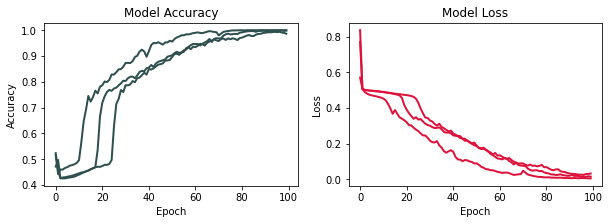

In [11]:
rn_model = resnet_model(X_train.shape[1:], num_models = number_models, dropout_rate = dropout_rate, num_dense_nodes=64, learning_rate = learning_rate)
rn_model.compile(verbose = 1)
rn_model.summary()


if nukeBright==26:
    epochs = 200
rn_model.train_models_with_one_trainset(X_train, y_train,
                                        sample_weights = train_weight,
                                        batch_size = batch_size, 
                                        train_epochs = epochs,
                                        verbose = 1)



fig = pyl.figure(figsize=(10,3))

ax1 = pyl.subplot(121)
for k in range(number_models):
    ax1.plot(rn_model.classifiers[k].history['accuracy'], color='darkslategray', linewidth=2)
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2 = pyl.subplot(122)
for k in range(number_models):
    ax2.plot(rn_model.classifiers[k].history['loss'], color='crimson', linewidth=2)
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

pyl.show()
pyl.close()

# Save the Model

In [12]:
saveModel = True
if saveModel:
    rn_model.saveModel(mean,std,save_dir=f'RNML_KBmod_CFHTmodelSave_{nukeBright}_{nukeFaint}_wRotAug_2', random_split_seed=410)
    print('saved')


   saved to RNML_KBmod_CFHTmodelSave_25.5_27.0_wRotAug_2/model_0

   saved to RNML_KBmod_CFHTmodelSave_25.5_27.0_wRotAug_2/model_1

   saved to RNML_KBmod_CFHTmodelSave_25.5_27.0_wRotAug_2/model_2

saved


# Validation

Finally, we use the model trained above to make predictions on the test/validation sample. We then compare these predicted labels with the original ones, and derive a prediction accuracy. 

In [13]:
preds_test = rn_model.predict(X_test, verbose=1)

preds_train = rn_model.predict(X_train, verbose=1)




7/7 [==============================] - 0s 26ms/step


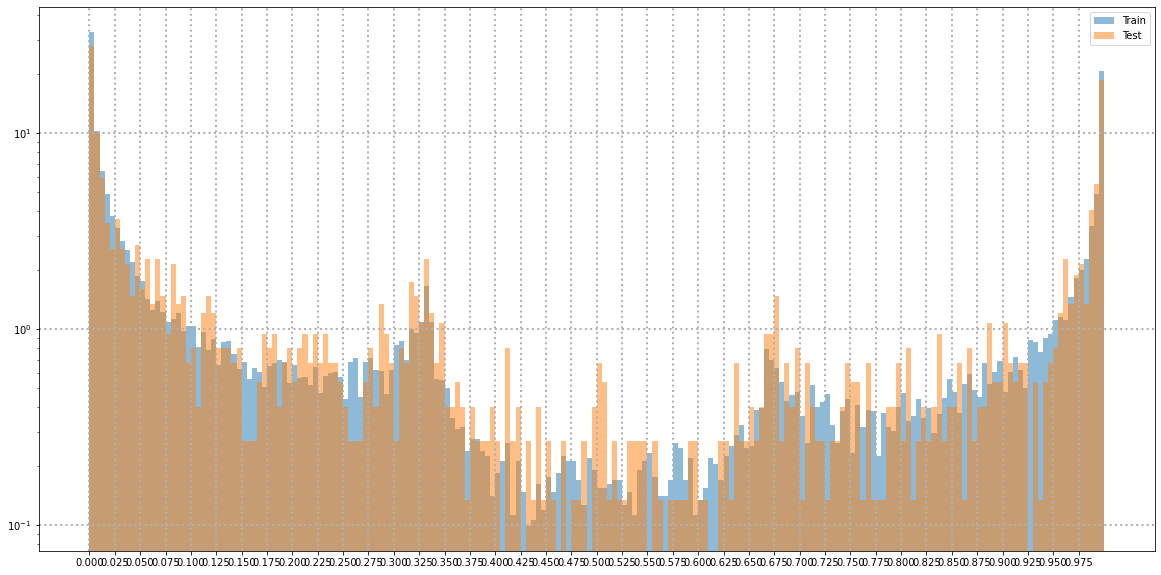

In [14]:

pyl.figure(figsize=(20,10))
pyl.hist(preds_train[:, 1], bins=200, density=True,alpha=0.5, label='Train', log=True)
pyl.hist(preds_test[:, 1], bins=200, density=True,alpha=0.5,label='Test', log=True)
pyl.xticks(np.arange(0., 1., 0.025))
pyl.grid(linestyle=':', lw=2)
pyl.legend()
pyl.show()

1798
25.50 0.5718 1.0000 1.00 152.0
25.75 0.1802 1.0000 0.99 144.0
26.00 0.0353 1.0000 0.99 149.0
26.25 0.0382 1.0000 0.96 100.0
26.50 0.0291 0.9800 0.88 44.0
26.75 0.2933 0.9761 1.00 25.0

Number of false-marked candidates with P>0.25: 155.0
Number of sources marked as real with P>0.25: 614.0


/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encou

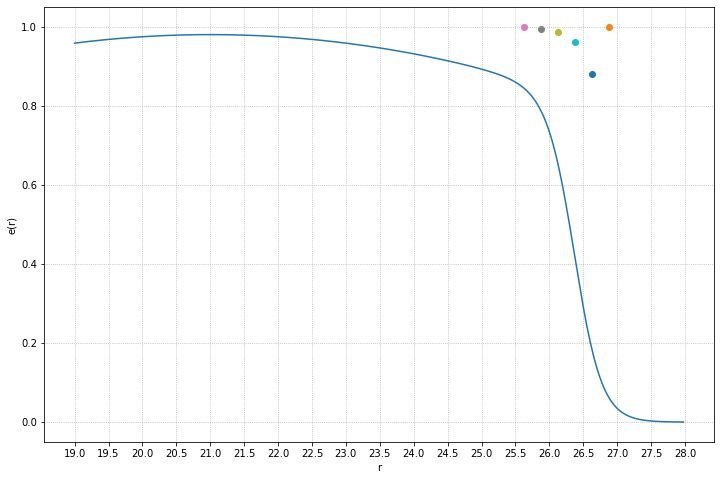

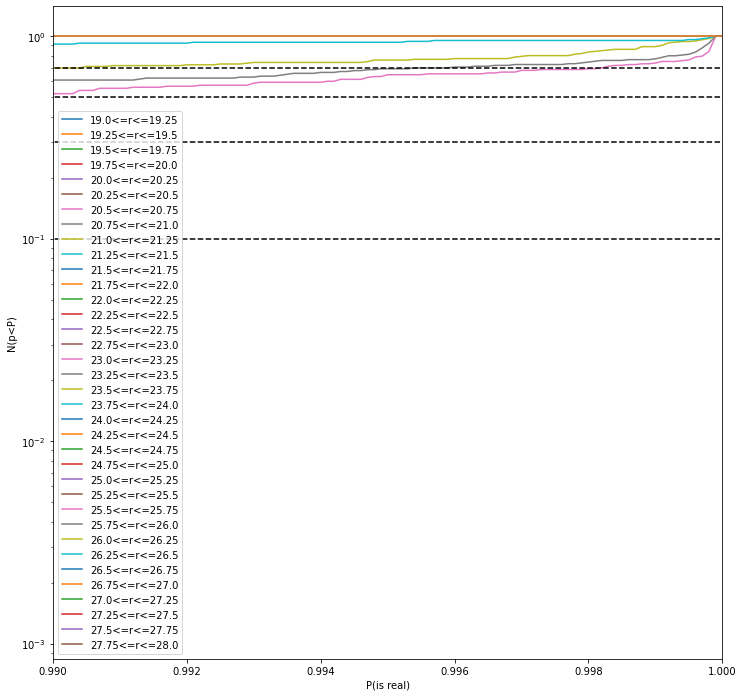

In [15]:

def Eff(m,  eff_max=0.8295, c=0.0054, M_0=26.3803,sig= 0.2016  ):
    return (eff_max-c*(m-21.0)**2)/(1+np.exp((m-M_0)/sig))

# measure the distribution of p values as a function of magnitude
eff_fig = pyl.figure('Efficiency Estimate', figsize=(12, 8))
eff_sp = eff_fig.add_subplot(111)
eff_sp.set_xlabel('r')
eff_sp.set_ylabel('e(r)')
                  
figure = pyl.figure('P-value histogram', figsize=(12, 12))
sp = figure.add_subplot(111)

good_p_value = 0.25
m_step = 0.25

print(len(np.where(preds_test>good_p_value)[0]))

bins = np.linspace(0.0,1.0,10000)
n_false = bins*0.0
n_found = 0.0
K = np.sum(np.less(bins,good_p_value))
n_bin_diff = 0
for m in np.arange(19.,28.,m_step):
    # plot the P-value cumulative distributions
    w = np.where( ((source_details[test_index, 5]-m)>=0) & ((source_details[test_index, 5]-m)<=m_step) )
    p_values = preds_test[w[0],1]
    
    n = bins*0.0
    k = ((p_values-bins[0])/(bins[1]-bins[0])).astype(np.int)
    for i in k:
        n[i:]+=1.0
    n_found+=n[-1]-n[K]
    n/=n[-1]
    
    
    # plot the efficiency curve estimate
    
    sp.plot(bins,n,label=f'{m}<=r<={m+m_step}')
    eff_sp.scatter(m+m_step/2.,1.0-n[K])
    if len(p_values)>0:
        print('{:.2f} {:.4f} {:.4f} {:.2f} {}'.format( m, np.min(p_values), np.max(p_values), 1.0-n[K], n_found-n_bin_diff ))
    n_bin_diff = n_found
    
emags = np.arange(19.,28.,m_step/10.)
eff_sp.plot(emags,Eff(emags, eff_max=0.98))
eff_sp.set_xticks(np.arange(19, 28.25,0.5))

# now sum up the false positives
w = np.where( (source_details[test_index, 5])==0) 
p_values_false = preds_test[w[0],1]
k = ((p_values_false-bins[0])/(bins[1]-bins[0])).astype(np.int)
for i in k:
    n_false[:i]+=1.0

print()
print(f'Number of false-marked candidates with P>{good_p_value}:',np.sum(n_false[K]))
print(f'Number of sources marked as real with P>{good_p_value}:',n_found)

n_false/=n_false[0]
pyl.plot(bins, n_false,'k:', lw=4)

eff_sp.grid(linestyle=':')
    
pyl.plot([0, 1], [0.1, 0.1], 'k--')
pyl.plot([0, 1], [0.3, 0.3], 'k--')
pyl.plot([0, 1], [0.5, 0.5], 'k--')
pyl.plot([0, 1], [0.7, 0.7], 'k--')
pyl.plot([good_p_value, good_p_value], [0, 1], 'k:')

sp.legend()
sp.set_yscale('log')
sp.set_xlim(0.99,1.0)
pyl.xlabel('P(is real)')
pyl.ylabel('N(p<P)')
pyl.show()